# Lesson 27 - Random Forests

### The following topics are discussed in this notebook:
* Overview of random forest classifiers.
* Building random forest models in Scikit-Learn.

## Random Forests

An **ensemble** model is one that generates its predictions by combining the predictions from several simpler models. There are two voting schemes that can be using a classification ensemble. When using **hard voting**, the individual models will use their predictions for a given observation to vote for the class to be assigned to the observation by the ensemble. In a **soft-voting** scheme, the individual models will each produce an estimated probability distribution over the possible classes, and these will then be averaged across all of the models to generate the ensemble's estimate for the probability distribution. 

It is often the case that the ensemble model will have better predictive performance than any of the individual models from which it is built.

A **random forest** is an ensemble of many decision trees. To ensure that the trees are different from one another, each tree is trained on a different subset of the training set. Assume that our training set contains `n` observations. When building a tree model to be used in a random forest, a sample of size `n` is drawn from the training set, with replacement. This sort of sampling is referred to as **bootstrap** sampling.

Since the sampling is done with replacement, each sample will likely be different from every other sample, which will encourage differences in the trees making up the random forest. The random forest implementation in Scikit-Learn further encourages diversity among the trees in a forest by randomly selecting the feature on which to split at each stage in the construction of a tree in the forest. 



## Random Forest Classifiers in Scikit-Learn

Random forest models are created in Scikit-Learn as instances of the `RandomForestClassifier` class, which is found in the `sklearn.ensemble` module. We will import that now, along with some other Scikit-Learn tools that we will need in this lesson.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## Example 1: Synthetic Data with Two Features

We will use a synthetic dataset in our first example of a random forest. The dataset is generated in the cell below. 

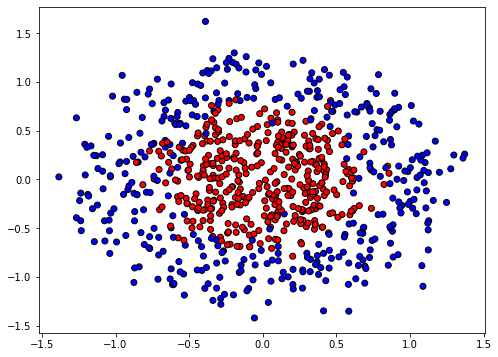

In [2]:
X, y = make_circles(800, noise=0.2, factor=0.4, random_state=1)

plt.figure(figsize=[8,6])
plt.scatter(X[:,0], X[:,1], c=y, cmap='bwr', edgecolor='k')
plt.show()

We now create training, validation, and test sets using a 60/20/20 split.

In [3]:
X_train, X_hold, y_train, y_hold = train_test_split(X, y, test_size=0.4, random_state=1, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_hold, y_hold, test_size=0.5, random_state=1, stratify=y_hold)

print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(480,)
(160,)
(160,)


For the purposes of comparison, we will create a decision tree model first. In the cell below, we perform hyperparameter tuning to select an appropriate value of `max_depth`. 

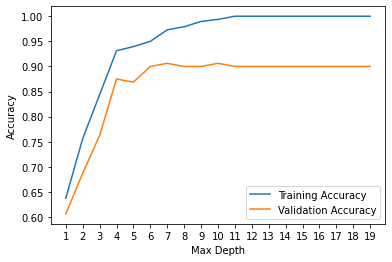

In [4]:
tr_acc = []
va_acc = []
depth_list = range(1,20)

for d in depth_list:
    temp_mod = DecisionTreeClassifier(max_depth=d, random_state=1)
    temp_mod.fit(X_train, y_train)
    tr_acc.append(temp_mod.score(X_train, y_train))
    va_acc.append(temp_mod.score(X_valid, y_valid))
    
plt.figure(figsize=([6,4]))
plt.plot(depth_list, tr_acc, label='Training Accuracy')
plt.plot(depth_list, va_acc, label='Validation Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.xticks(depth_list)
plt.legend()
plt.show()

It appears that we get the best performance on the validation set when `max_depth=7`. We confirm this below.

In [5]:
ix_best = np.argmax(va_acc)
best_md = depth_list[ix_best]
print('Optimal Value of max_depth:', best_md)

Optimal Value of max_depth: 7


We now build our decision tree model, and calculate its training and validation accuracy. 

In [6]:
tree_mod = DecisionTreeClassifier(max_depth=best_md, random_state=1)
tree_mod.fit(X_train, y_train)

print('Training Accuracy:  ', round(tree_mod.score(X_train, y_train),4))
print('Validation Accuracy:', round(tree_mod.score(X_valid, y_valid),4))

Training Accuracy:   0.9729
Validation Accuracy: 0.9062


The figure below displays the classification regions determined by our decision tree model. 

C:\Users\Nick\AppData\Local\Temp/ipykernel_8424/1847791803.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xticks, yticks, class_grid, cmap='bwr', zorder=1, vmin=0, vmax=1)


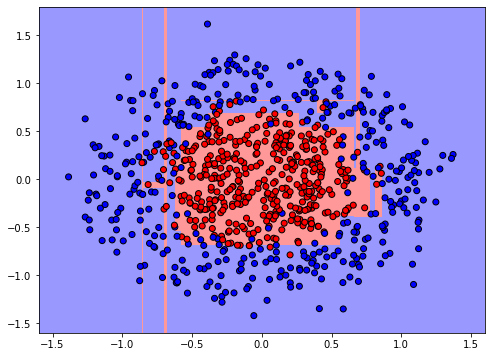

In [7]:
n, x0, x1, y0, y1 = 400, -1.6, 1.6, -1.6, 1.8
xticks = np.linspace(x0, x1, n)
yticks = np.linspace(y0, y1, n)
grid_pts = np.transpose([np.tile(xticks,n), np.repeat(yticks,n)])
class_grid = tree_mod.predict(grid_pts).reshape(n,n)
plt.figure(figsize=[8,6])
plt.pcolormesh(xticks, yticks, class_grid, cmap='bwr', zorder=1, vmin=0, vmax=1)
plt.fill([x0,x0,x1,x1], [y0,y1,y1,y0], 'white', alpha=0.6, zorder = 2)
plt.scatter(X[:,0], X[:,1], c=y, cmap='bwr', edgecolor='k', zorder=3)
plt.show()

we will now construct our random forest model. When creating our model, we set the following parameters:

* `n_estimators` - This determines the number of trees to be used in the forest. Have have selected 500. As a general rule, using more trees will likely result in better performance, but also will increase the computational complexity of the algorithm. 
* `max_depth` - This the the maximum depth to be used for the individual trees. Because of the ensembling that takes place in a random forest, these models are less prone to overfitting than individual tree models. As a result, we can typically set the `max_depth` parameter high without much fear of overfitting.
* `random_state` - Unsurpisingly, the random forest algorithm involves randomness. This parameter allows us to set a seed for the random number generator so that we can get reproducible results. 

After constructing our random forest model, we will determine its training and validation accuracy. 

In [8]:
forest_mod = RandomForestClassifier(n_estimators=500, max_depth=32, random_state=1)
forest_mod.fit(X_train, y_train)

print('Training Accuracy:  ', forest_mod.score(X_train, y_train))
print('Validation Accuracy:', forest_mod.score(X_valid, y_valid))

Training Accuracy:   1.0
Validation Accuracy: 0.91875


The forest model got a validation accuracy of 91.877%, which is higher than the 90.62% obtained by the tree model. As a result, we will select the forest as our final model. We will now calculate the test accuracy for our forest model. 

In [9]:
print('Test Set Accuracy:  ', forest_mod.score(X_test, y_test))

Test Set Accuracy:   0.89375


The cell below shows classification region determined by our forest model. 

C:\Users\Nick\AppData\Local\Temp/ipykernel_8424/2995354114.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xticks, yticks, class_grid, cmap='bwr', zorder=1, vmin=0, vmax=1)


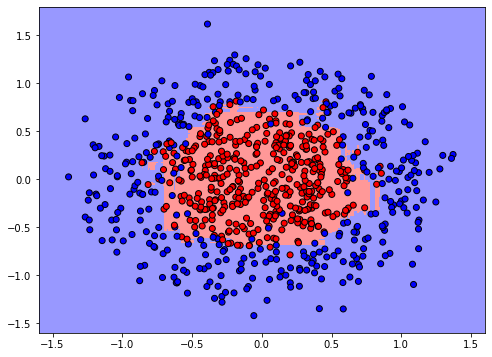

In [10]:
n, x0, x1, y0, y1 = 400, -1.6, 1.6, -1.6, 1.8
xticks = np.linspace(x0, x1, n)
yticks = np.linspace(y0, y1, n)
grid_pts = np.transpose([np.tile(xticks,n), np.repeat(yticks,n)])
class_grid = forest_mod.predict(grid_pts).reshape(n,n)
plt.figure(figsize=[8,6])
plt.pcolormesh(xticks, yticks, class_grid, cmap='bwr', zorder=1, vmin=0, vmax=1)
plt.fill([x0,x0,x1,x1], [y0,y1,y1,y0], 'white', alpha=0.6, zorder = 2)
plt.scatter(X[:,0], X[:,1], c=y, cmap='bwr', edgecolor='k', zorder=3)
plt.show()

## Example: The Iris Dataset

We will now build a random forest classifier to apply to the iris dataset. 

In [11]:
iris = pd.read_csv(filepath_or_buffer='Data/iris_mod.txt', sep='\t')
iris.head(n=10)

,sepal_length,sepal_width,petal_length,petal_width,species
0,6.8,3.7,6.1,2.5,virginica
1,6.8,3.0,5.5,2.1,virginica
2,5.9,3.2,5.4,2.2,virginica
3,6.5,3.4,6.0,2.0,virginica
4,6.2,3.0,4.3,1.3,versicolor
5,6.5,3.2,4.9,1.6,versicolor
6,4.7,3.5,1.0,0.2,setosa
7,5.2,3.8,1.5,0.3,setosa
8,5.0,3.4,1.3,0.2,setosa
9,6.6,3.0,5.1,2.0,virginica


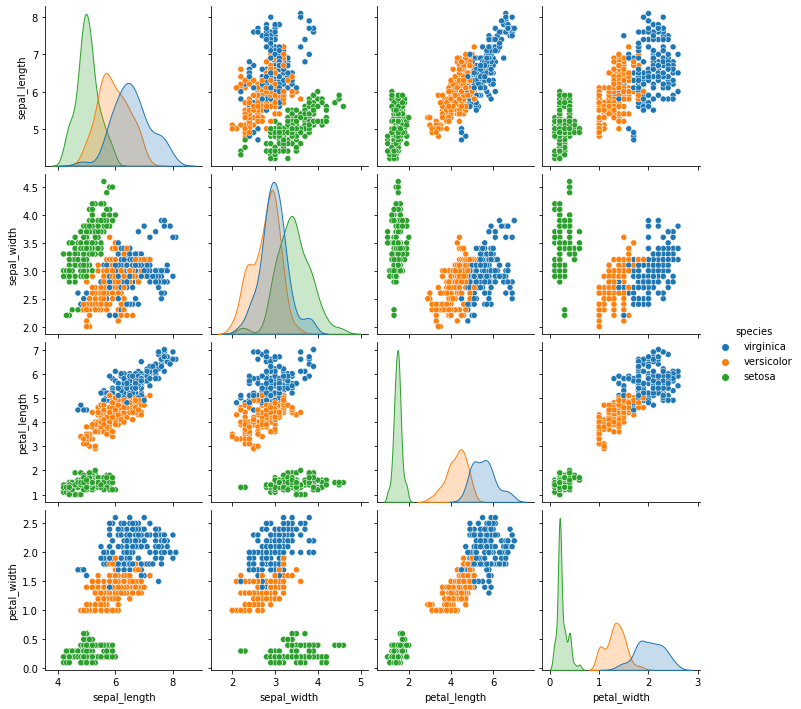

In [12]:
import seaborn as sns

g = sns.pairplot(iris, hue="species")
plt.show()

We extract our feature and label arrays, and create training and test sets using an 80/20 split. 

In [13]:
X = iris.iloc[:,:4]
y = iris.iloc[:,4]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

We will now create our random forest model. We also calculate the model's accuracy on the training and test sets. 

In [14]:
iris_forest = RandomForestClassifier(n_estimators=500, max_leaf_nodes=32, random_state=1)

iris_forest.fit(X_train, y_train)

print('Training Accuracy:', round(iris_forest.score(X_train, y_train),4))
print('Testing Accuracy: ', round(iris_forest.score(X_test, y_test),4))

Training Accuracy: 1.0
Testing Accuracy:  0.9583
